In [1]:
# Input info
# noIn_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
# input_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_30/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_30/"
# donor = 0
# noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_3"
# input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_3"
# donor = 0
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_3"

noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/dendro_bc/results/noInput/knn/kparam_30"
input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/dendro_bc/results/inputOnly/knn/kparam_30"
donor = 3
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor3/dendro_bc/knn_kparam_30"
clone_col = "den_clust"


# config
conditions = ["inputOnly", "noInput" ]

# params
p_thresh = 0.1 

atac_col = "cluster_labels"
#clone_col = "name" #den_clust, "Variants", "den_clust"


In [2]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
noIn_don_indir =  join(noIn_indir,"sepDonors", f"donor{donor}")
input_don_indir =  join(input_indir,"sepDonors", f"donor{donor}")


In [4]:
noIn_df = pd.read_csv(join(noIn_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
noIn_df
noInput_hyper = pd.read_csv(join(noIn_don_indir, "hypergeo_padjusted.csv"),  index_col=0)

input_df = pd.read_csv(join(input_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
input_hyper = pd.read_csv(join(input_don_indir, "hypergeo_padjusted.csv"),  index_col=0)
input_df

,index,variable,value,method
0,3_C1,0,0.0,global_all
1,3_C1,1,0.0,global_all
2,3_C1,2,0.0,global_all
3,3_C1,3,0.0,global_all
4,3_C1,4,0.0,global_all
5,3_C1,5,0.0,global_all
6,3_C1,6,0.0,global_all
7,3_C1,7,0.0,global_all
8,3_C1,8,0.0,global_all
9,3_C1,10,0.0,global_all


In [5]:
in_input_ncells_f = join(input_don_indir, 'ncells.csv')
out_input_ncells_f = join(outdir, 'input_ncells.csv')

in_input_adjHyper_f = join(input_don_indir, "hypergeo_padjusted.csv")
out_input_adjHyper_f = join(outdir, "hypergeo_padjusted.csv")
cmd = f"cp {in_input_adjHyper_f} {out_input_adjHyper_f}"
!{cmd}

in_noInput_ncells_f = join(noIn_don_indir, 'ncells.csv')
out_noInput_ncells_f = join(outdir, 'noInput_ncells.csv')

in_noInput_adjHyper_f = join(noIn_don_indir, "hypergeo_padjusted.csv")
out_noInput_adjHyper_f = join(outdir, "hypergeo_padjusted.csv")
cmd = f"cp {in_noInput_adjHyper_f} {out_noInput_adjHyper_f}"
!{cmd}

in_ncells = pd.read_csv(in_input_ncells_f)
noIn_ncells = pd.read_csv(in_noInput_ncells_f)
in_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_input_ncells_f)
noIn_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_noInput_ncells_f)




In [6]:
set(input_hyper.index) - set(noInput_hyper.index)
set(noInput_hyper.index) - set(input_hyper.index) 

set()

In [7]:
all_clones = set(noInput_hyper.index).union(set(input_hyper.index) )
all_clones

{'3_C1'}

In [8]:
input_hyper

,0,1,2,3,4,5,6,7,8,10,11,13,14
3_C1,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999


In [9]:
(noInput_hyper==0).all()

3     False
9     False
10    False
13    False
14    False
dtype: bool

In [10]:
len(all_clones )

1

In [11]:
len(set(input_hyper.index))

1

In [12]:
all_clones-set(noInput_hyper.index)

set()

In [13]:
input_hyper

,0,1,2,3,4,5,6,7,8,10,11,13,14
3_C1,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999


In [14]:
all_clones

{'3_C1'}

In [15]:
(input_hyper == 0).all()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
10    False
11    False
13    False
14    False
dtype: bool

In [17]:
input_hyper

,0,1,2,3,4,5,6,7,8,10,11,13,14
3_C1,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999


In [18]:
noInput_hyper

,3,9,10,13,14
3_C1,0.09999,0.09999,0.09999,0.09999,0.09999


{'3_C1'}


ValueError: The number of observations cannot be determined on an empty distance matrix.

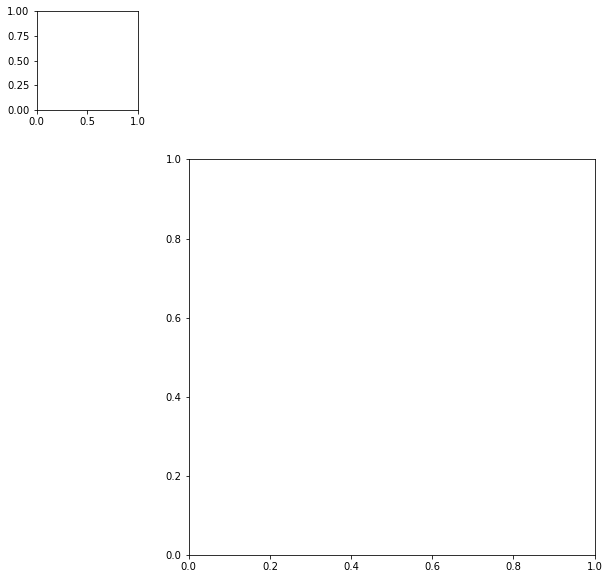

In [16]:
input_hyper = pd.read_csv(in_input_adjHyper_f, index_col=0)
noInput_hyper = pd.read_csv(in_noInput_adjHyper_f, index_col=0) #.loc[input_hyper.index]

all_clones = set(noInput_hyper.index).union(set(input_hyper.index) )

#noInput_hyper.loc[list(all_clones-set(noInput_hyper.index)),:] = 0
noInput_hyper = noInput_hyper.transpose()
if len(all_clones-set(noInput_hyper.columns)) != 0:
    noInput_hyper[list(all_clones-set(noInput_hyper.columns))] = 0
noInput_hyper = noInput_hyper.transpose()
input_hyper = input_hyper.transpose()
print(set(input_hyper.columns))
if len(list(all_clones-set(input_hyper.columns))) != 0:    
    print('here')
    print(list(all_clones-set(input_hyper.columns)))
    input_hyper.loc[:, list(all_clones-set(input_hyper.columns))] = 0
input_hyper = input_hyper.transpose()

#input_hyper.loc[all_clones-set(input_hyper.index),:] = 0
if len(input_hyper) > 1:
    g=sns.clustermap((input_hyper))
    g.fig.suptitle("Input pvalue")
    inds = g.dendrogram_row.dendrogram["leaves"]
    g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

# g=sns.clustermap(-np.log10(input_hyper))
# g.fig.suptitle("Input(-log 10 pvalue, 1 is p=0.1)")
# inds = g.dendrogram_row.dendrogram["leaves"]
# g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

#cols = g.dendrogram_col.dendrogram["leaves"]
# g2 = sns.clustermap(-np.log10(noInput_hyper.iloc[inds]), row_cluster=False)
# g2.fig.suptitle("Cultured (-log 10 pvalue, 1 is p=0.1)")
if len(noInput_hyper) > 1:
    g2 = sns.clustermap((noInput_hyper.iloc[inds]), row_cluster=False)
    g2.fig.suptitle("Cultured pvalue")

    g2.fig.savefig(join(outdir, f"cultured_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

In [ ]:
# merge_pval = pd.merge(input_df.rename({"value":"p_val"}, axis=1), 
#                       noIn_df.rename({"value":"p_val"}, axis=1), on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
# merge_pval
# merge_pval.to_csv(join(outdir, "shuffle_p_vals.csv"))

# save to combined directory
input_df.to_csv(join(outdir, "input_shuffle_results_pvals.csv"))
noIn_df.to_csv(join(outdir, "noInput_shuffle_results_pvals.csv"))
noInput_hyper.to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
input_hyper.to_csv(join(outdir, "input_hypergeo_pvals.csv"))

# noInput_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
# input_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "input_hypergeo_pvals.csv"))


## Get overlapping clones and clusters and use same clone indices from input to noInput

In [ ]:
for ind, in_val in input_df[input_df["value"] < p_thresh].groupby("method"):
    print(ind)
    noIn_val = noIn_df.loc[noIn_df["method"] == ind]
    noIn_val = noIn_val.loc[noIn_val["value"]< p_thresh]
    
    noIn_clones = set(noIn_val["index"].values)
    in_clones = set(in_val["index"].values)
    curr_clones = list(noIn_clones.union(in_clones))
    
    noIn_clust = set(noIn_val["variable"].values)
    in_clust = set(in_val["variable"].values)
    curr_clust = list(noIn_clust.union(in_clust))
    
    if (len(curr_clust)==0 or len(curr_clones)==0):
        print('no significant results')
        print(ind)
        continue
     
    
    curr_in_df = pd.DataFrame(index=curr_clones, columns=curr_clust)
    curr_noIn_df = pd.DataFrame(index=curr_clones, columns=curr_clust)

    
    in_val = in_val.set_index(["index", "variable"])
    noIn_val = noIn_val.set_index(["index", "variable"])
    
 
    def get_element_pval(x,y, val):
#         print('val')
#         print(val.head())
        if (y.name, x.name) in val.index:
            return val.loc[(y.name, x.name), "value"]
        else: 
            return 1
         
#     curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: in_val.loc[(y.name, x.name), "value"] if (x.name,y.name) in in_val.index else 1, 
#                                                                   axis=1))
    curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=in_val), axis=1))
    
    curr_noIn_df = curr_noIn_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=noIn_val), 
                                                                      axis=1))

    #print(curr_in_df.head())
    
    
    # Transpose both matrices
    curr_noIn_df = curr_noIn_df.transpose()
    curr_in_df = curr_in_df.transpose()
    
    # Plot the input first and then noInput with same clone indices
    
    if (curr_in_df.shape[0] > 1) and (curr_in_df.shape[1] > 1):
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, figsize=(12,12))
        cols = g.dendrogram_col.dendrogram["leaves"]
        g2 = sns.clustermap(curr_noIn_df.iloc[:,cols], col_cluster=False, vmax=float(p_thresh)+0.05, figsize=(12,12))
    else:
        f = plt.figure()
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)
        g2 = sns.clustermap(curr_noIn_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)

    title = f"{ind}\np-val;cutoff is {p_thresh}; vmax {float(p_thresh)+0.05}"
    g.fig.suptitle("only input cells\n" + title)
    g2.fig.suptitle("only cultured cell\n" + title)
    #g.ax_cbar.set(title=title)  # g.ax_cbar.set(title="-log10 p-value")
    
    g.fig.savefig(join(outdir, f"input_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    
    g2.fig.savefig(join(outdir, f"cultured_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    